In [1]:
import json
import chess.pgn
import os
import re
import pandas as pd
import numpy as np
import pickle
from glob import glob
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
def get_db_total(file_list, columns_of_interest):
    df_total = pd.DataFrame(columns=columns_of_interest)
    for pkl_path in file_list:
        with open(pkl_path, 'rb') as pickle_file:
            df = pickle.load(pickle_file)
            df_total = pd.concat([df_total, df], axis = 0).reset_index(drop=True)
    return df_total

def clean_data(df_total):
    df = df_total
    df['WhiteResult'] = df['Result']
    df = df.replace({'WhiteResult' : { '1-0' : 1, '1/2-1/2' : 0.5, '0-1' : 0 }})
    df['Year'] = df['Date'].str[:4]
    df.drop(columns=['Result', 'Date'], inplace=True)
    #clean
    df = df.dropna()
    df = df[df['Year']!='????']
    df = df[df['WhiteResult']!='*']
    df = df.astype({"BlackElo": int, "WhiteElo": int, "WhiteResult": float, "Year": int})
    df = df[df['BlackElo']>=1000]
    df = df[df['WhiteElo']>=1000]
    df['avg_elo'] = df[['WhiteElo', 'BlackElo']].mean(axis=1)
    df['diff_elo'] = df['WhiteElo'] - df['BlackElo']    
    df = df[abs(df['diff_elo'])<=500]
    df.drop(columns=['WhiteElo', 'BlackElo'], inplace=True)
    return df

def visualize_data_ditribution(df):    
    # Custom the histogram:
    fig = sns.jointplot(x=df["avg_elo"], y=df["diff_elo"], kind='hex',
                        marginal_kws=dict(bins=30, fill=True))
    fig.fig.suptitle("Games distribution", x=0.1, y=.95, horizontalalignment='left', verticalalignment='top')
    plt.xlabel("Average elo")
    plt.ylabel("Elo difference (W - B)")
    plt.show()
    
def plot_regression_model(model, data=[]):
    #https://plotly.com/python/ml-regression/
    #https://jakevdp.github.io/PythonDataScienceHandbook/04.12-three-dimensional-plotting.html
    import plotly.graph_objects as go
    xrange = np.linspace(1500, 3000, 1001)#np.arange(1500, 3000, 50)
    yrange = np.linspace(-200, 200, 1001)#np.arange(-200, 200, 10)
    xx, yy = np.meshgrid(xrange, yrange)

    # Run model
    pred = model.predict(np.c_[xx.ravel(), yy.ravel()])
    pred = pred.reshape(xx.shape)

    # Generate the plot
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    #ax.contour3D(xx, yy, pred, 50)#, cmap='binary')
    ax.plot_surface(xx, yy, pred)#, cmap='binary')
        
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')
    #ax.plot(x,0.5, color='purple', alpha=0.1)
    
def get_regressor_model(fascia_elo_points, b_plot=True):
    #from sklearn.svm import SVR
    from sklearn.ensemble import RandomForestRegressor
    #from sklearn.metrics import mean_squared_error

    X=fascia_elo_points[:,[0]]
    y=fascia_elo_points[:,1]

    #svr = SVR(kernel="rbf", C=1, gamma='scale').fit(X, y)
    #yfit = svr.predict(X)
    raf = RandomForestRegressor(max_depth=4, random_state=0, criterion='absolute_error').fit(X, y)
    yfit = raf.predict(X)
    
    if b_plot:
        plt.scatter(X, y, s=5, color="blue", label="original")
        plt.plot(X, yfit, lw=2, color="red", label="fitted")
        plt.title("Fascia elo: "+ str(elo))
        plt.legend()
        plt.show()        
    return raf

def get_average_results_binned(df, avg_elo_bins=[1000, 2900, 20], diff_elo_bins=[-1000, 1000, 70], b_plot=False):
    x_bin = np.linspace(avg_elo_bins[0], avg_elo_bins[1], num=avg_elo_bins[2], endpoint=True, retstep=False, dtype=None, axis=0)
    y_bin = np.linspace(diff_elo_bins[0], diff_elo_bins[1], num=diff_elo_bins[2], endpoint=True, retstep=False, dtype=None, axis=0)
    H, xedges, yedges, binnumber = stats.binned_statistic_2d(df["avg_elo"], df["diff_elo"], 
                                                             values = df["WhiteResult"], statistic='mean', 
                                                             #bins = 30) 
                                                             bins = [x_bin, y_bin])
    H_count, xedges, yedges, binnumber  = stats.binned_statistic_2d(df["avg_elo"], df["diff_elo"], 
                                                             values = df["WhiteResult"], statistic='count', 
                                                             #bins = 30) 
                                                             bins = [x_bin, y_bin])

    x_middle_rounded=[]
    for ii in range(0,len(xedges)-1):
        x_middle_rounded.append(np.round((xedges[ii]+xedges[ii+1])/2))
    y_middle_rounded=[]
    for ii in range(0,len(yedges)-1):
        y_middle_rounded.append(np.round((yedges[ii]+yedges[ii+1])/2))
    HH = pd.DataFrame(H, index=x_middle_rounded, columns=y_middle_rounded)
    #
    HH_count = pd.DataFrame(H_count, index=x_middle_rounded, columns=y_middle_rounded)
    #HH = HH.loc[1400:2650]
    #HH_count = HH_count.loc[1400:2650]
    if b_plot:
        ax = plt.axes()
        sns.heatmap(HH.T, ax = ax)#,
                   #xticklabels=1, yticklabels=1)
        ax.set_title('Empirical probability of victory heatmap')
        ax.set(xlabel='Average elo', ylabel='Elo difference (W - B)')
        plt.show()
            
        '''
        #from mpl_toolkits.mplot3d import Axes3D
        x = HH.columns
        y = HH.index
        X,Y = np.meshgrid(x,y)
        Z = HH
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        #ax.plot_surface(X, Y, Z)
        ax.set_title('Win probability scatter')
        ax.scatter(X, Y, Z)
        ax.view_init(20,110)
        '''
    return HH, HH_count

def get_regressors_for_each_elo(HH, b_plot=False):
    regressors={}
    for elo in HH.index:
        fascia_elo = HH.loc[[elo]]
        fascia_elo_points = fascia_elo.unstack().reset_index().dropna().loc[:,['level_0',0]].values
        regressors[elo] = get_regressor_model(fascia_elo_points, b_plot=b_plot)
    return regressors

def get_elo_diff_for_equal_winning_prob(HH, HH_count, regressors):
    from scipy import optimize
    xx = HH.index
    zeros = []
    for avg_elo in HH.index:
        model = regressors[avg_elo]
        def fun(x):
            return model.predict(np.asarray([[x]]))[0] - 0.5
        sol = optimize.root_scalar(fun, x0=50, x1=-50)
        zeros.append(sol.root)
    yy = zeros

    slope, intercept, r, p, std_err = stats.linregress(xx, yy)

    def myfunc(x):
      return slope * x + intercept
    mymodel = list(map(myfunc, xx))

    # Dati per il grafico a barre
    bar_data = HH_count.sum(axis=1).values
    bar_labels = xx.astype(int).map(str)

    # Dati per la linea
    line_data = yy

    # Crea il grafico a barre
    fig, ax1 = plt.subplots()

    fig.suptitle("Elo difference to equalize winning probability", fontsize=16)
    # Configura il primo asse y per il grafico a barre
    color = 'tab:blue'
    ax1.set_ylabel("Elo difference (W - B)", color=color) 
    ax1.set_xlabel("Average elo")
    ax1.plot(bar_labels, line_data, color=color, label='Elo computed by the model')
    ax1.plot(bar_labels, mymodel, 'r', label='Regression line: y={:.5f}x+{:.5f}'.format(slope,intercept))
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
    ax1.set_xticklabels(bar_labels, rotation=45)

    # Crea un secondo asse y per la linea
    ax2 = ax1.twinx() 

    # Configura il secondo asse y per la linea
    color = 'tab:grey'
    ax2.set_xlabel('Gruppi')
    ax2.set_ylabel('Number of games to train the model', color=color)
    ax2.bar(bar_labels, bar_data, color=color, alpha=0.2)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.legend()

    plt.show()
    
def get_white_advantage_same_elo(HH, HH_count):
    xx=HH.index
    yy=HH.loc[:, 0]

    slope, intercept, r, p, std_err = stats.linregress(xx, yy)

    def myfunc(x):
      return slope * x + intercept
    mymodel = list(map(myfunc, xx))

    # Dati per il grafico a barre
    bar_data = HH_count.sum(axis=1).values
    bar_labels = xx.astype(int).map(str)

    # Dati per la linea
    line_data = yy

    # Crea il grafico a barre
    fig, ax1 = plt.subplots()

    fig.suptitle("White's winning probability vs an equal opponent (+-50 elo)", fontsize=16)
    # Configura il primo asse y per il grafico a barre
    color = 'tab:blue'
    ax1.set_ylabel("Winning probability", color=color) 
    ax1.set_xlabel("Average elo")
    ax1.plot(bar_labels, yy, color=color, label='Winning probability computed by the model')
    ax1.plot(bar_labels, mymodel, 'r', label='Regression line: y={:.5f}x+{:.5f}'.format(slope,intercept))
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.legend()
    ax1.set_xticklabels(bar_labels, rotation=45)

    # Crea un secondo asse y per la linea
    ax2 = ax1.twinx() 

    # Configura il secondo asse y per la linea
    color = 'tab:grey'
    ax2.set_xlabel('Gruppi')
    ax2.set_ylabel('Number of games to train the model', color=color)
    ax2.bar(bar_labels, bar_data, color=color, alpha=0.2)
    ax2.tick_params(axis='y', labelcolor=color)
    #ax2.legend()

    plt.show()

In [26]:
#CHESSBASE

In [20]:
PATH = r'data\chessbase'
file_list = [y for x in os.walk(PATH) for y in glob(os.path.join(x[0], '*date.pkl'))]
columns_of_interest = ['Result', 'BlackElo', 'WhiteElo', 'Date', 'ECO']

df_total = get_db_total(file_list, columns_of_interest)

In [21]:
df = clean_data(df_total)

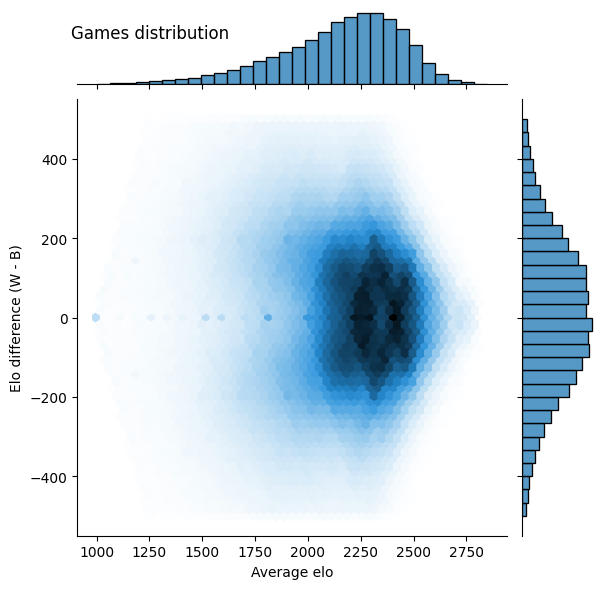

In [22]:
visualize_data_ditribution(df)

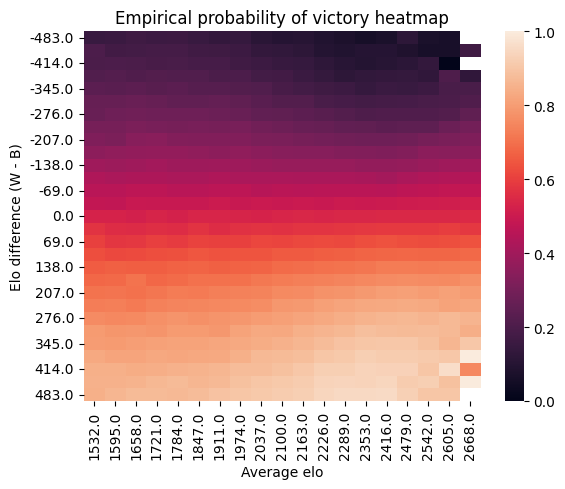

In [23]:
HH, HH_count = get_average_results_binned(df, avg_elo_bins=[1500, 2700, 20], diff_elo_bins=[-500, 500, 30], 
                                          b_plot=True)

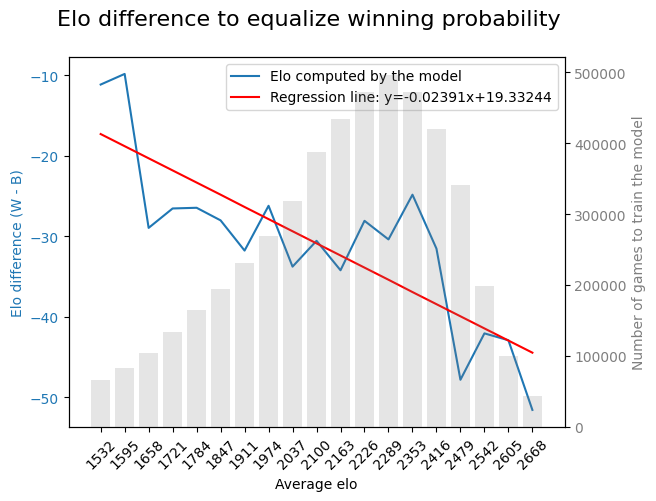

In [24]:
get_elo_diff_for_equal_winning_prob(HH, HH_count, get_regressors_for_each_elo(HH, b_plot=False))

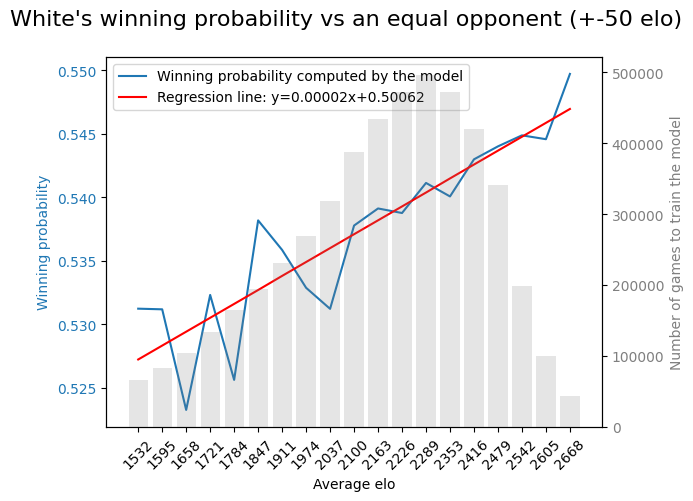

In [25]:
get_white_advantage_same_elo(HH, HH_count)

In [10]:
#LICHESS

In [27]:
PATH = r'data\Lichess Elite Database'
file_list = [y for x in os.walk(PATH) for y in glob(os.path.join(x[0], '*date.pkl'))]
columns_of_interest = ['Result', 'BlackElo', 'WhiteElo', 'Date', 'ECO']

df_total = get_db_total(file_list, columns_of_interest)

In [28]:
df = clean_data(df_total)

In [29]:
df.shape

(2778067, 5)

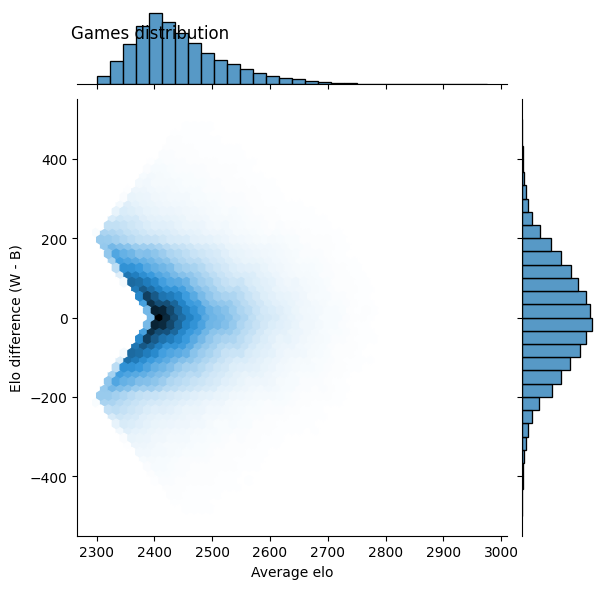

In [30]:
visualize_data_ditribution(df)

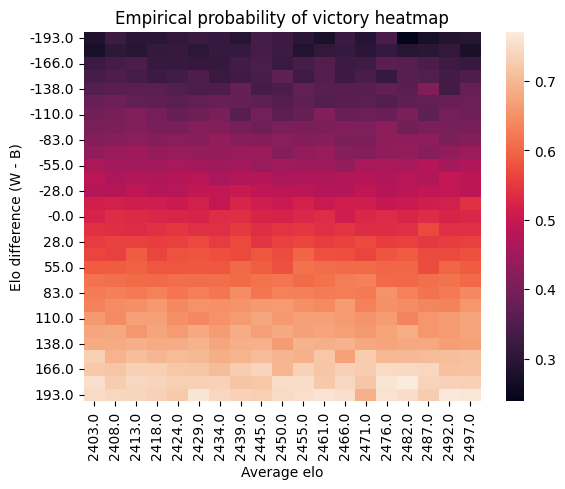

In [38]:
HH, HH_count = get_average_results_binned(df, avg_elo_bins=[2400, 2500, 20], diff_elo_bins=[-200, 200, 30], 
                                          b_plot=True)

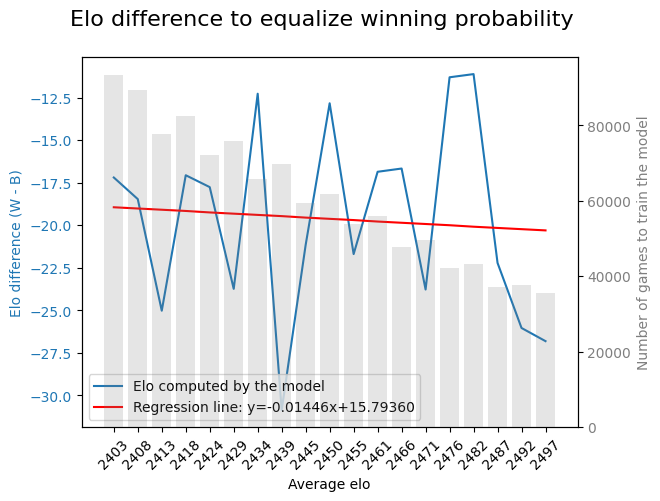

In [39]:
get_elo_diff_for_equal_winning_prob(HH, HH_count, get_regressors_for_each_elo(HH, b_plot=False))

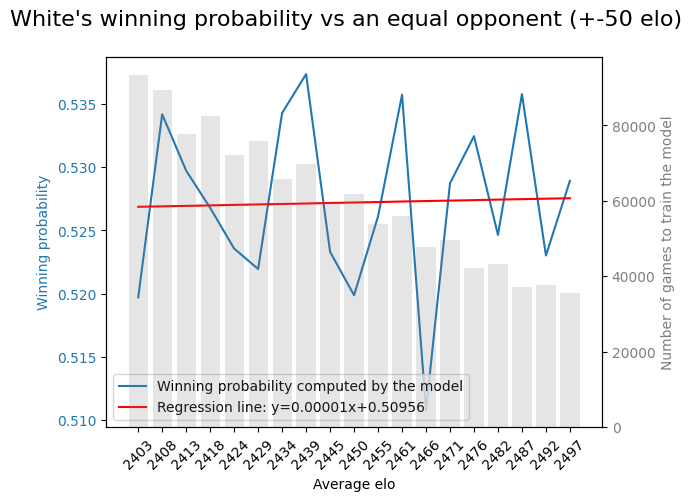

In [40]:
get_white_advantage_same_elo(HH, HH_count)